# Double/Debiased ML for Partially Linear IV Model

References: 

https://arxiv.org/abs/1608.00060


https://www.amazon.com/Business-Data-Science-Combining-Accelerate/dp/1260452778

The code is based on the book.



# Partially Linear IV Model

We consider the partially linear structural equation model:
\begin{eqnarray}
 &  Y - D\theta_0 = g_0(X) + \zeta,  & E[\zeta \mid Z,X]= 0,\\
  & Z = m_0(X) +  V,   &  E[V \mid X] = 0. 
\end{eqnarray}


Note that this model is not a regression model unless $Z=D$.  The model  is a canonical
model in causal inference, going back to P. Wright's work on IV methods for estimaing demand/supply equations, with the modern difference being that $g_0$ and $m_0$ are nonlinear, potentially complicated functions of high-dimensional $X$.  


The idea of this model is that there is a structural or causal relation between $Y$ and $D$, captured by $\theta_0$, and $g_0(X) + \zeta$ is the stochastic error, partly explained by covariates $X$.  $V$ and $\zeta$ are stochastic errors that are not explained by $X$. Since $Y$ and $D$ are jointly determined, we need an external factor, commonly referred to as an instrument, $Z$ to create exogenous variation
in $D$.   Note that $Z$ should affect $D$.  The $X$ here serve again as confounding factors, so we can think of variation in $Z$ as being exogenous only conditional on $X$. 


The causal DAG this model corresponds to is given by:
$$
Z \to D,  X \to (Y, Z, D),  L \to (Y,D),
$$
where $L$ is the latent confounder affecting both $Y$ and $D$, but not $Z$.



---

# Example

A simple contextual example is from biostatistics, where $Y$ is a health outcome and $D$ is indicator of smoking.  Thus, $\theta_0$ is captures the effect of smoking on health.  Health outcome $Y$ and smoking behavior $D$ are treated as being jointly determined.  $X$ represents patient characteristics, and $Z$ could be a doctor's advice not to smoke (or another behavioral treatment) that may affect the outcome $Y$ only through shifting the behavior $D$, conditional on characteristics $X$.   

----



# PLIVM in Residualized Form

The PLIV model above can be rewritten in the following residualized form:
$$
  \tilde Y = \tilde D \theta_0 + \zeta,   \quad  E[\zeta \mid V,X]= 0,
$$
where
$$
 \tilde Y = (Y- \ell_0(X)),  \quad \ell_0(X) = E[Y \mid X] \\
   \tilde D = (D - r_0(X)), \quad r_0(X) = E[D \mid X] \\
   \tilde Z = (Z- m_0(X)), \quad m_0(X) = E[Z \mid X].
$$
   The tilded variables above represent original variables after taking out or "partialling out"
  the effect of $X$.  Note that $\theta_0$ is identified from this equation if $V$ 
  and $U$ have non-zero correlation, which automatically means that $U$ and $V$
  must have non-zero variation.

  

-----

# DML for PLIV Model

Given identification, DML  proceeds as follows

Compute the estimates $\hat \ell_0$, $\hat r_0$, and $\hat m_0$ , which amounts
to solving the three problems of predicting $Y$, $D$, and $Z$ using
$X$, using any generic  ML method, giving us estimated residuals 
$$
\tilde Y = Y - \hat \ell_0(X), \\ \tilde D= D - \hat r_0(X), \\ \tilde Z = Z- \hat m_0(X).
$$ 
The estimates should be of a cross-validated form, as detailed in the algorithm below. 

Estimate $\theta_0$ by the the intstrumental
variable regression of $\tilde Y$ on $\tilde D$ using $\tilde Z$ as an instrument.
Use the conventional inference for the IV regression estimator, ignoring
the estimation error in these residuals. 

The reason we work with this residualized form is that it eliminates the bias
arising when solving the prediction problem in stage 1. The role of cross-validation
is to avoid another source of bias due to potential overfitting.

The estimator is adaptive,
in the sense that the first stage estimation errors do not affect the second 
stage errors.

In [1]:
# Import relevant packages
using Pkg
Pkg.add("CSV"), using CSV
Pkg.add(Pkg.PackageSpec(;name="DataFrames", version="1.3.4")), using DataFrames
Pkg.add("GLM"), using GLM
Pkg.add("Random"), using Random
Pkg.add("MLDataUtils"), using MLDataUtils
Pkg.add("MLBase"), using MLBase
Pkg.add("FixedEffectModels"), using FixedEffectModels
Pkg.add("Lasso"), using Lasso
Pkg.add("MLJ"), using MLJ
Pkg.add("DecisionTree"), using DecisionTree
Pkg.add("RData"), using RData
Pkg.add("GLMNet"), using GLMNet
Pkg.add("PrettyTables"), using PrettyTables
Pkg.add("DataConvenience"), using DataConvenience
Pkg.add("Econometrics"), using Econometrics
Pkg.add("Vcov"), using Vcov
Pkg.add("CovarianceMatrices"), using CovarianceMatrices
Pkg.add("RegressionTables"), using RegressionTables
Pkg.add("StatsFuns"), using StatsFuns
Pkg.add("PyPlot"), using PyPlot
Pkg.add("Plots"), using Plots

    Updating registry at `C:\Users\User\.julia\registries\General`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
   Resolving package versions...
  No Changes to `C:\Users\User\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\User\.julia\environments\v1.6\Manifest.toml`
Precompiling project...
  ✓ CovarianceMatrices
  1 dependency successfully precompiled in 15 seconds (215 already precompiled)
   Resolving package versions...
  No Changes to `C:\Users\User\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\User\.julia\environments\v1.6\Manifest.toml`
Precompiling project...
  ✓ CovarianceMatrices
  1 dependency successfully precompiled in 12 seconds (215 already precompiled)
   Resolving package versions...
  No Changes to `C:\Users\User\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\User\.julia\environments\v1.6\Manifest.toml`
Precompiling project...
  ✓ CovarianceMatrices
  1 dependency successfully precompiled

  1 dependency precompiled but a different version is currently loaded. Restart julia to access the new version
   Resolving package versions...
  No Changes to `C:\Users\User\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\User\.julia\environments\v1.6\Manifest.toml`
Precompiling project...
  ✓ CovarianceMatrices
  1 dependency successfully precompiled in 8 seconds (215 already precompiled)
  1 dependency precompiled but a different version is currently loaded. Restart julia to access the new version


(nothing, nothing)

In [2]:
using Pkg, CSV, DataFrames, StatsModels, GLM, Random, RData, MLDataUtils, MLBase, FixedEffectModels, Lasso, MLJ, DecisionTree, GLMNet, PrettyTables

In [437]:
# load data
rdata_read = RData.load("../data/ajr.RData")
AJR = rdata_read["AJR"]
names(AJR)
println("Number of Rows : ", size(AJR)[1],"\n","Number of Columns : ", size(AJR)[2],) #rows and columns

Number of Rows : 64
Number of Columns : 11


In [438]:
first(AJR, 5)

,GDP,Exprop,Mort,Latitude,Neo,Africa,Asia,Namer,Samer,logMort
,Float64,Float64,Float64,Float64,Int32,Int32,Int32,Int32,Int32,Float64
1,8.39,6.5,78.2,0.3111,0,1,0,0,0,4.35927
2,7.77,5.36,280.0,0.1367,0,1,0,0,0,5.63479
3,9.13,6.39,68.9,0.3778,0,0,0,0,1,4.23266
4,9.9,9.32,8.55,0.3,1,0,0,0,0,2.14593
5,9.29,7.5,85.0,0.2683,0,0,0,1,0,4.44265


In [439]:
function DML2_for_PLIVM(x , d , z, y, dreg , yreg , zreg, nfold)
     # Num ob observations
    nobser = size(x,1)
    
    # Define folds indices 
    foldid = collect(Kfold(size(x)[1], nfold))
    
    # Create array to save errors 
    ytil = ones(nobser)
    dtil = ones(nobser)
    ztil = ones(nobser);

    println("Folds: " )

    for i in 1:nfold
        
        # Lasso regression, excluding folds selected 
        dfit = dreg(x[foldid[i],:], d[foldid[i]])
        zfit = zreg(x[foldid[i],:], z[foldid[i]])
        yfit = yreg(x[foldid[i],:], y[foldid[i]])
        
        # Predict estimates using the 
        dhat = apply_forest(dfit,x[Not(foldid[i]),:])
        zhat = apply_forest(zfit,x[Not(foldid[i]),:])
        yhat = apply_forest(yfit,x[Not(foldid[i]),:])

        # Save errors 
        dtil[Not(foldid[i])] = (d[Not(foldid[i])] - dhat)
        ztil[Not(foldid[i])] = (z[Not(foldid[i])] - zhat)
        ytil[Not(foldid[i])] = (y[Not(foldid[i])] - yhat)
        println(i)

    end

    data = DataFrame(ytil = ytil, dtil = dtil, ztil = ztil)
    ivfit = reg(data, @formula(ytil ~  + (dtil ~ ztil)))
    # OLS clustering at the County level
    coef_est =  ivfit.coef[2]
    se = FixedEffectModels.coeftable(ivfit).mat[1,2]
    println( "\n Coefficient (se) =", coef_est, "(",se,")" )
    
    Final_result = ("coef_est" => coef_est , "se" => se , "dtil" => dtil , "ytil" => ytil , "ztil" => ztil);
       
end

DML2_for_PLIVM (generic function with 1 method)

-----

# Emprical Example:  Acemoglu, Jonsohn, Robinson (AER).


* Y is log GDP;
* D is a measure of Protection from Expropriation, a proxy for 
quality of insitutions;
* Z is the log of Settler's mortality;
* W are geographical variables (latitude, latitude squared, continent dummies as well as interactions)


In [440]:
y = AJR[!,"GDP"]
d = AJR[!,"Exprop"]
z = AJR[!,"logMort"];

In [441]:
Y = DataFrame(GDP = y)
D = DataFrame(Exprop = d)
Z = DataFrame(logMort = z);

In [442]:
xraw_formula = @formula(GDP ~ Latitude+ Africa+Asia + Namer + Samer)
xraw_dframe = ModelFrame(xraw_formula, AJR)
xraw1  = ModelMatrix(xraw_dframe)
xraw = xraw1.m
size(xraw)

(64, 6)

In [443]:
x_formula = @formula(GDP ~ -1 + Latitude + Latitude2 + Africa + Asia + Namer + Samer
    + Latitude*Latitude2 + Latitude*Africa + Latitude*Asia + Latitude*Namer + Latitude*Samer
    + Latitude2*Africa + Latitude2*Asia + Latitude2*Namer + Latitude2*Samer
    + Africa*Asia + Africa*Namer + Africa*Samer
    + Asia*Namer + Asia*Samer
    + Namer*Samer)
x_dframe = ModelFrame( x_formula, AJR)
x1 = ModelMatrix(x_dframe)
x = x1.m
size(x1)

(64, 21)

In [102]:
Africa = x_dframe;

In [445]:
X = DataFrame(Latitude = x_dframe.data[2], Latitude2 = x_dframe.data[3], Africa = x_dframe.data[4],
    Asia = Africa = x_dframe.data[5], Namer = Africa = x_dframe.data[6], Samer = Africa = x_dframe.data[7])
size(X)

(64, 6)

Information from random Forest [link1](https://stackoverflow.com/questions/35578041/why-do-i-get-different-randomforest-outcomes-between-r-and-python), [link2](https://stackoverflow.com/questions/45612922/random-forest-in-r-and-sklearn)

In [446]:
y_model = DataFrame(y_model = y);

In [448]:
function dreg( x_1 , d_1 )
    
    if d_1 != nothing && ( typeof(d_1) != String )
        mtry1 = convert(Int64,findmax(round( ( size(x_1)[ 2 ]/3 ), digits = 0))[1])
    else
        mtry1 = convert(Int64,round(sqrt( size(x)[ 2 ] ), digits = 0))
    end
    
    if d_1 != nothing && ( typeof(d_1) != String )
        nodesize1 = 5
    else
        nodesize1 = 1
    end
    n_subfeatures=-1; n_trees=10; partial_sampling=0.7; max_depth=-1
    min_samples_leaf= nodesize1; min_samples_split=2; min_purity_increase=0.0; seed=0
    
    RFmodel =  build_forest(d_1, x_1, n_subfeatures, n_trees, partial_sampling, max_depth, min_samples_leaf, min_samples_split, min_purity_increase; rng = seed)
end

function yreg( x_1, y_1 )
    
    if y_1 != nothing && ( typeof(y_1) != String )
        mtry1 = convert(Int64,findmax(round( ( size(x_1)[ 2 ]/3 ), digits = 0))[1])
    else
        mtry1 = convert(Int64,round(sqrt( size(x_1)[ 2 ] ), digits = 0))
    end
    
    if y_1 != nothing && ( typeof(y_1) != String )
        nodesize1 = 5
    else
        nodesize1 = 1
    end
    n_subfeatures=-1; n_trees=10; partial_sampling=0.7; max_depth=-1
    min_samples_leaf= nodesize1; min_samples_split=2; min_purity_increase=0.0; seed=0
    
    RFmodel =  build_forest(y_1, x_1, n_subfeatures, n_trees, partial_sampling, max_depth, min_samples_leaf, min_samples_split, min_purity_increase; rng = seed)
end
                
function zreg( x_1, z_1 )
    
    if z_1 != nothing && ( typeof(z_1) != String )
        mtry1 = convert(Int64,findmax(round( ( size(x_1)[ 2 ]/3 ), digits = 0))[1])
    else
        mtry1 = convert(Int64,round(sqrt( size(x_1)[ 2 ] ), digits = 0))
    end
    
    if z_1 != nothing && ( typeof(z_1) != String )
        nodesize1 = 5
    else
        nodesize1 = 1
    end
    n_subfeatures=-1; n_trees=10; partial_sampling=0.7; max_depth=-1
    min_samples_leaf= nodesize1; min_samples_split=2; min_purity_increase=0.0; seed=0
    
    RFmodel =  build_forest(z_1, x_1, n_subfeatures, n_trees, partial_sampling, max_depth, min_samples_leaf, min_samples_split, min_purity_increase; rng = seed)
end

DML2_RF = DML2_for_PLIVM(xraw, d, z, y, dreg, yreg, zreg, 20)

Folds: 
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20

 Coefficient (se) =0.7524130698167707(0.23630541190311558)


("coef_est" => 0.7524130698167707, "se" => 0.23630541190311558, "dtil" => [0.15565634920634874, -0.2791861111111107, -0.9777500000000012, 2.29963852813853, -0.31843055555555644, -2.6909138888888897, -1.139750000000002, 1.1712214285714273, -1.5625142857142862, -0.36003214285714336  …  0.797359523809523, 0.9724035714285719, 1.1681678571428575, -0.18468412698412617, -1.2077369047619042, -0.4859154761904758, 2.753840151515152, 0.2909972222222228, -0.30180833333333457, -2.4970499999999998], "ytil" => [0.2812396825396828, 0.8693749999999998, 0.12426785714285771, 1.230942424242425, 0.20469837662337653, -2.2161714646464654, -0.4307873015873014, 0.2022126984126995, -0.3882476190476183, -1.2033507936507934  …  -1.0349730158730157, 0.18190039682539627, 0.5981027777777772, 0.20425714285714314, -0.0898416666666666, -0.04134920634920647, 1.2455204545454546, 0.6519388888888891, -0.9406249999999998, -0.2312666666666674], "ztil" => [-0.04162269159816123, -0.47678027991012506, 0.5216786273234608, -1.676

In [18]:
print( "\n DML with Post-Lasso \n" )


 DML with Post-Lasso 


In [473]:
include("E:/causal_ml/hdmjl/hdmjl.jl")

In [20]:
include("hdmjl/hdmjl.jl")

In [520]:
function DML2_lasso_cv(x , d , z, y, dreg , yreg , zreg, nfold)
     # Num ob observations
    nobser = size(x,1)
    
    # Define folds indices 
    foldid = collect(Kfold(size(x)[1], nfold))
    
    # Create array to save errors 
    ytil = ones(nobser)
    dtil = ones(nobser)
    ztil = ones(nobser);

    println("Folds: " )

    for i in 1:nfold

        # Save errors 
        # Lasso regression, excluding folds selected 
        dtil= dreg(X[foldid[i],:], D[foldid[i],:])
        ztil= dreg(X[foldid[i],:], Z[foldid[i],:])
        ytil= dreg(X[foldid[i],:], Y[foldid[i],:])
        println(i)

    end

    data = DataFrame(ytil = ytil, dtil = dtil, ztil = ztil)
    
    ivfit = reg(data, @formula(ytil ~  + (dtil ~ ztil)))
    # OLS clustering at the County level
    coef_est =  ivfit.coef[2]
    se = FixedEffectModels.coeftable(ivfit).mat[1,2]
    println( "\n Coefficient (se) =", coef_est, "(",se,")" )
    
    Final_result = ("coef_est" => coef_est , "se" => se , "dtil" => dtil , "ytil" => ytil , "ztil" => ztil);
       
end

DML2_lasso_cv (generic function with 1 method)

In [708]:
function dreg(x_1, d_1)
    res_Y_0 = rlasso_arg( x_1, d_1, nothing, true, true, true, false, false, 
                    nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
    res_Y = rlasso(res_Y_0)["residuals"]
end

function yreg(x_1, y_1)
    res_D_0 = rlasso_arg( x_1, y_1, nothing, true, true, true, false, false, 
                        nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
    res_D = rlasso(res_D_0)["residuals"]
end

function yreg(x_1, z_1)
    res_D_0 = rlasso_arg( x_1, z_1, nothing, true, true, true, false, false, 
                        nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
    res_D = rlasso(res_D_0)["residuals"]
end

DML2_lasso = DML2_lasso_cv(x, d, z, y, dreg, yreg, zreg, 20)

Folds: 
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20

 Coefficient (se) =0.7782511656099669(0.2437254403283589)


("coef_est" => 0.7782511656099669, "se" => 0.2437254403283589, "dtil" => [0.42430581177259696, -0.24666234450727587, -1.0583282867651111, 2.188375255345433, -1.8782883990195196, -1.1654082960605885, 1.2447673643601305, -1.169661745180405, -1.7139492578947118, 0.4693814992375751  …  -1.6613272485839419, 1.118848411836776, 1.3681024140945102, 0.7692145325051474, -1.04517236576525, -0.39869655373452806, 2.3383452583015596, 0.5014331712267962, -0.3709624176155717, -1.9944323896247003], "ytil" => [0.9689353107994076, 0.6447321854257281, 0.2570539922513273, 1.226784392636004, -1.7217395716336379, -0.5374858531100929, 0.35091650763851084, -0.2834659404427178, -1.2380313968997498, -0.025874336376500384  …  0.15025753728803382, -0.8213401019633628, 0.13557634864584367, 0.3811080498207977, -0.0849561977712886, 0.18835445022512276, 1.2125187800066666, 0.7077334091690932, -1.1720689586319308, -0.18448952875381464], "ztil" => [-0.8572705491233079, 0.013523939115180128, 0.6239965679679942, -1.643276

In [275]:
# Compare Forest vs Lasso

In [522]:
mods = [DML2_RF, DML2_lasso];
mods_name = ["DML2_RF", "DML2_lasso"];

In [523]:
RMSE_Y = []
RMSE_D = []
RMSE_Z = []

for i in mods
    push!(RMSE_Y, sqrt(sum(i[4][2].^2)/length(i[4][2])))
    push!(RMSE_D, sqrt(sum(i[3][2].^2)/length(i[3][2])))
    push!(RMSE_Z, sqrt(sum(i[5][2].^2)/length(i[5][2])))
end

result = DataFrame([mods_name RMSE_Y RMSE_D RMSE_Z], [:Models, :RMSE_Y, :RMSE_D, :RMSE_Z])
pretty_table(result; formatters = ft_printf("%5.10f"))

┌────────────┬──────────────┬──────────────┬──────────────┐
│     Models │       RMSE_Y │       RMSE_D │       RMSE_Z │
│        Any │          Any │          Any │          Any │
├────────────┼──────────────┼──────────────┼──────────────┤
│    DML2_RF │ 0.8072244996 │ 1.2993424184 │ 0.9519269381 │
│ DML2_lasso │ 0.8225635548 │ 1.2708855149 │ 0.9498346380 │
└────────────┴──────────────┴──────────────┴──────────────┘


# Examine if we have weak instruments

In [820]:
data1 = DataFrame(ytil = DML2_lasso[4][2], dtil = DML2_lasso[3][2], ztil = DML2_lasso[5][2]);

In [848]:
ols = reg(data1, @formula(dtil ~ 0 + ztil),Vcov.robust())

                         Linear Model                         
Number of obs:              61   Degrees of freedom:          1
R2:                      0.111   R2 Adjusted:             0.096
F Statistic:           6.23798   p-value:                 0.015
       Estimate Std.Error t value Pr(>|t|) Lower 95%  Upper 95%
---------------------------------------------------------------
ztil  -0.438198  0.175448 -2.4976    0.015 -0.789146 -0.0872497


In [822]:
data2 = DataFrame(ytil = DML2_RF[4][2], dtil = DML2_RF[3][2], ztil = DML2_RF[5][2]);

In [823]:
reg(data2, @formula(dtil ~ 0 + ztil),Vcov.robust())

                         Linear Model                         
Number of obs:              64   Degrees of freedom:          1
R2:                      0.094   R2 Adjusted:             0.080
F Statistic:            5.0997   p-value:                 0.027
      Estimate Std.Error  t value Pr(>|t|) Lower 95%  Upper 95%
---------------------------------------------------------------
ztil  -0.41886  0.185479 -2.25825    0.027 -0.789511 -0.0482083


#  We do have weak instruments, because t-stats in regression $\tilde D \sim \tilde Z$ are less than 4 in absolute value

In [824]:
function DML_AR_PLIV(rY, rD, rZ, grid, alpha)
    n = size(rY)[1]
    Cstat = zeros(size(grid))
    
    for i in 1:length(grid)
        Cstat[i] = n * ((mean((rY - grid[i] * rD).* rZ))^2) / var((rY - grid[i] * rD).* rZ)
    end
    
    data_ar = DataFrame(grid = grid, Cstat = Cstat)
    
    LB = minimum(data_ar[data_ar[:,2] .< chisqinvcdf(1, 1 - alpha), :][1])
    UB = maximum(data_ar[data_ar[:,2] .< chisqinvcdf(1, 1 - alpha), :][1])
    
    println( "UB =" , UB, "LB ="  ,LB)

    plot(grid, Cstat, color=:black)
    xlabel!("Effect of institutions")
    ylabel!("Statistic")
    vline!([LB], color=:red, label="1", linestyle=:dash)
    vline!([UB], color=:red, label="2", linestyle=:dash)
    hline!([chisqinvcdf(1, 1 - alpha)], color=:skyblue, linestyle=:dash)
end

DML_AR_PLIV (generic function with 2 methods)

UB =2.0LB =0.37


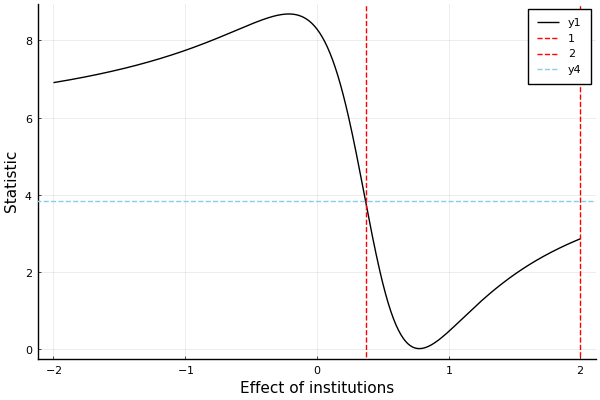

In [825]:
DML_AR_PLIV(data1[1], data1[2], data1[3], collect(range( -2, 2.001, step = 0.01 )), 0.05 )

UB =2.0LB =0.34


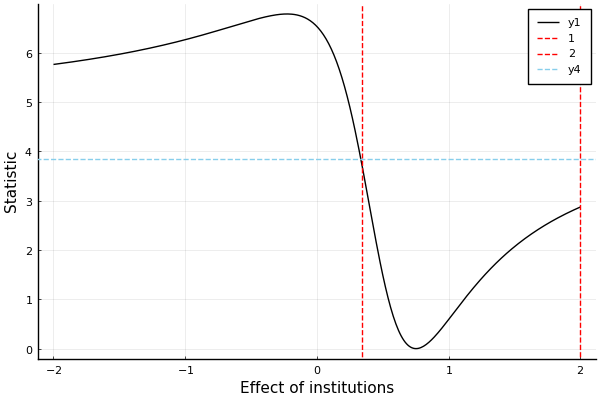

In [826]:
DML_AR_PLIV(data2[1], data2[2], data2[3], collect(range( -2, 2.001, step = 0.01 )), 0.05 )